<a href="https://colab.research.google.com/github/hmtuan0315/NPL/blob/main/BERT_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%config IPCompleter.use_jedi = False
!pip install transformers
!pip install kora
from kora import drive
drive.link_nbs()

In [ ]:
!pwd

/content


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoModel, BertTokenizerFast
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import random
import numpy as np
# %run ../Utils.ipynb

In [3]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
fake_df = pd.read_csv(r'D:/pytorch dataset and model/Fake.csv')
true_df = pd.read_csv(r'D:/pytorch dataset and model/True.csv')
fake_df['trg'] = 0
true_df['trg'] = 1
fake_df.fillna(" ",inplace = True)
true_df.fillna(" ",inplace = True)

In [ ]:
print(f'fake: {len(fake_df)}')
print(f'true: {len(true_df)}')

fake: 23481
true: 21417


In [ ]:
df = pd.concat([fake_df, true_df]).reset_index(drop=True)
df.head()

,title,text,subject,date,trg
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [ ]:
df['sent'] = df.title + " " + df.text
df = df[['sent', 'trg']]
df.head()

,sent,trg
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [ ]:
df.tail()

,sent,trg
44893,'Fully committed' NATO backs new U.S. approach...,1
44894,LexisNexis withdrew two products from Chinese ...,1
44895,Minsk cultural hub becomes haven from authorit...,1
44896,Vatican upbeat on possibility of Pope Francis ...,1
44897,Indonesia to buy $1.14 billion worth of Russia...,1


<AxesSubplot:xlabel='trg', ylabel='count'>

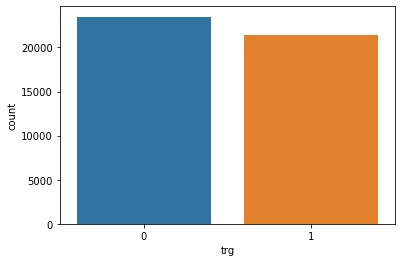

In [ ]:
sns.countplot(x=df.trg)

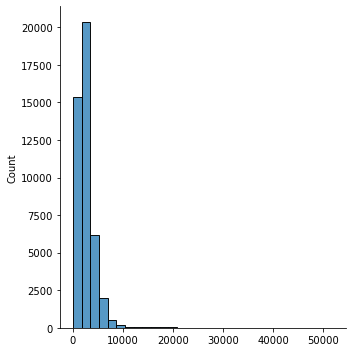

In [ ]:
len_arr = [len(sent) for sent in df.sent]
len_arr = pd.Series(len_arr)
sns.displot(x=len_arr, bins=30)

In [ ]:
len_arr.describe()

count    44898.000000
mean      2550.221413
std       2172.578772
min         31.000000
25%       1318.000000
50%       2270.000000
75%       3189.000000
max      51893.000000
dtype: float64

In [ ]:
count = 0
for i in len_arr:
    if i >5000:
        count = count + 1
print(count)

3538


# Preprocessing

In [ ]:
def remove_small_word(sent):
    filtered_sentence = ' '.join([w for w in sent.split() if len(w) > 2])
    return filtered_sentence
def remove_stopword(sent):
    stop_words = set(stopwords.words('english'))
    filtered_sentence = ' '.join([w for w in sent.split() if not w.lower() in stop_words])
    return filtered_sentence

text = df.sent.values
text = list(map(removing_new_line, text))
print("html")
text = list(map(remove_html_tag, text))
print("accent")
text = list(map(remove_accent_char, text))
print("contractions")
text = list(map(expand_contractions, text))
print("special")
text = list(map(remove_special_characters, text))
print("stopwords")
text = list(map(remove_stopword, text))
print("small")
text = list(map(remove_small_word, text))
text = [sent.lower() for sent in text]

html
accent
contractions
special
stopwords
small


In [ ]:
df.sent = text
df.to_csv(r'D:/pytorch dataset and model/fake real processed dataset.csv')

In [ ]:
df = pd.read_csv(r'D:/pytorch dataset and model/fake real processed dataset.csv')
text = df.sent

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
tok_text = []
attention_mask = []
def tokenize_and_encode(sents):
    for i, sent in enumerate(sents):
        print(i)
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = None,           # Pad & truncate all sentences.
    #                         pad_to_max_length = True,
                            padding='max_length',
                            return_attention_mask = True,   # Construct attn. masks.
                            truncation=True,
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )
        tok_text.append(encoded_dict.input_ids)
        attention_mask.append(encoded_dict.attention_mask)

# tok_text = list(map(tokenize_and_encode, text[0:2]))
tokenize_and_encode(text)

twodim_enc_text = torch.cat(tok_text, dim=0)
twodim_enc_attn = torch.cat(attention_mask, dim=0)


In [5]:
# torch.save(twodim_enc_text, 'bert_fakenew_enc_text')
# torch.save(twodim_enc_attn, 'bert_fakenew_enc_attention')
loaded = torch.load('./drive/MyDrive/Colab Notebooks/bert text classification/bert_fakenew_enc_text')
attn_loaded = torch.load('./drive/MyDrive/Colab Notebooks/bert text classification/bert_fakenew_enc_attention')
loaded.size()

torch.Size([44898, 512])

In [6]:
df = pd.read_csv(r'./drive/MyDrive/Colab Notebooks/bert text classification/fake real processed dataset.csv')
text = df.sent

In [7]:
X = loaded[12000:32000]
y = torch.tensor(df.trg.values)[12000:32000]
attn_loaded = attn_loaded[12000:32000]

In [8]:
from torch.utils.data import DataLoader, TensorDataset, random_split
dataset = TensorDataset(X, attn_loaded, y)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, valid_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [9]:
batch_size = 8
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.to(device)

In [11]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [12]:
from transformers import get_linear_schedule_with_warmup

epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [13]:
print(len(train_loader))
print(len(valid_loader))

2000
250


In [14]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [15]:
def train(model, train_loader, optimizer):
    model.train()
    total_train_loss = 0
    for ind, batch in enumerate(train_loader):
        data = batch[0].to(device)
        mask = batch[1].to(device)
        trg = batch[2].to(device)
        
        print(f'train: {ind}')
        model.zero_grad() 
        outputs = model(data, 
                    token_type_ids=None, 
                    attention_mask=mask, 
                    labels=trg)
        loss = outputs[0]
        logits = outputs[1]
        
        total_train_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        loss.backward()
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_loader)
    return avg_train_loss

def evaluate(model, valid_loader):
    model.eval()
    total_valid_loss = 0
    total_eval_accuracy = 0
    for ind, batch in enumerate(valid_loader):
        data = batch[0].to(device)
        mask = batch[1].to(device)
        trg = batch[2].to(device)
        
        print(f'valid: {ind}')
        with torch.no_grad():  
            outputs = model(data, 
                        token_type_ids=None, 
                        attention_mask=mask, 
                        labels=trg)
        loss = outputs[0]
        logits = outputs[1]

        total_valid_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        trg = trg.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, trg)
    avg_valid_loss = total_valid_loss / len(valid_loader)
    avg_val_accuracy = total_eval_accuracy / len(valid_loader)
    return avg_valid_loss, avg_val_accuracy

train_loss_arr = []
valid_loss_arr = []
valid_acc_arr = []
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer)
    valid_loss, valid_acc = evaluate(model, valid_loader)
    print(f'epoch: {epoch}, train_loss:{train_loss}, val_loss: {valid_loss}, val_acc:{valid_acc}')
    train_loss_arr.append(train_loss)
    valid_loss_arr.append(valid_loss)
    valid_acc_arr.append(valid_acc)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
train: 1753
train: 1754
train: 1755
train: 1756
train: 1757
train: 1758
train: 1759
train: 1760
train: 1761
train: 1762
train: 1763
train: 1764
train: 1765
train: 1766
train: 1767
train: 1768
train: 1769
train: 1770
train: 1771
train: 1772
train: 1773
train: 1774
train: 1775
train: 1776
train: 1777
train: 1778
train: 1779
train: 1780
train: 1781
train: 1782
train: 1783
train: 1784
train: 1785
train: 1786
train: 1787
train: 1788
train: 1789
train: 1790
train: 1791
train: 1792
train: 1793
train: 1794
train: 1795
train: 1796
train: 1797
train: 1798
train: 1799
train: 1800
train: 1801
train: 1802
train: 1803
train: 1804
train: 1805
train: 1806
train: 1807
train: 1808
train: 1809
train: 1810
train: 1811
train: 1812
train: 1813
train: 1814
train: 1815
train: 1816
train: 1817
train: 1818
train: 1819
train: 1820
train: 1821
train: 1822
train: 1823
train: 1824
train: 1825
train: 1826
train: 1827
train: 1828
train: 1829
train: 1830
train: 

In [20]:
torch.save(model.state_dict(), './drive/MyDrive/Colab Notebooks/bert text classification/bert_model.pth')

In [ ]:
model1 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
model1.to(device)

In [ ]:
model1.load_state_dict(torch.load('./drive/MyDrive/Colab Notebooks/bert text classification/bert_model.pth'))
model1.eval()

In [73]:
 predictions , true_labels = [], []
 def predict_testset(model, prediction_dataloader):
    model.eval()

    # Tracking variables 
    # Predict 
    for i, batch in enumerate(prediction_dataloader):
      # Add batch to GPU
        print(f'test: {i}')
        data = batch[0].to(device)
        mask = batch[1].to(device)
        trg = batch[2].to(device)
      
        with torch.no_grad():
          # Forward pass, calculate logit predictions
            outputs = model(data, token_type_ids=None, 
                            attention_mask=mask)
            
        logits = outputs[0]

      # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = trg.to('cpu').numpy()
      
      # Store predictions and true labels
        pred_labels_i = np.argmax(logits, axis=1).flatten()
        predictions.append(pred_labels_i)
        true_labels.append(label_ids)


In [23]:
print(train_loss_arr)
print(valid_loss_arr)

[0.04341263403886114, 0.003114115367006889, 0.0008098411489281716]
[0.005205579353438225, 0.008410096167659503, 0.011013940922231995]


In [ ]:
predict_testset(model1, test_loader)

In [75]:
cat_true_labels = np.concatenate(true_labels, axis=0)
cat_true_labels

array([0, 0, 1, ..., 1, 1, 0])

In [76]:
cat_predictions = np.concatenate(predictions, axis=0)
cat_predictions

array([0, 0, 1, ..., 1, 1, 0])

In [77]:
print(classification_report(cat_true_labels, cat_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1177
           1       1.00      1.00      1.00       823

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

